In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from astropy.units import jupiterMass, jupiterRad, a, day, earthRad, earthMass, solMass, solRad, AU
from sklearn.preprocessing import StandardScaler
#import seaborn as sns
scaler = StandardScaler()
from matplotlib.lines import Line2D

# File 1: reading file and first clustering: mass vs orbital period

Steps for reading data:
* Picking what parameters to keep for a specific test.
* Removing Nans, by removing from the dataframe planets that contain it for the chosen parameters.
* Standardizing data: Our variables are measured at different scales, so they won't contribute equally to the analysis. 

In [425]:
file_US="/home/bolacha/University/Project/code/data-example/all_data_US.rdb"
file_EU="/home/bolacha/University/Project/code/data-example/all_data_EU.rdb"
cat_solar="/home/bolacha/University/Project/code/data-example/solar_data.csv"

In [426]:
def read_file(file, removeNaN=False, params=0, standard=False):
    database = np.genfromtxt(file_EU, comments="--", skip_header=4,
                            dtype=None, delimiter="\t", encoding=None)
    df_exo = pd.DataFrame(database)
    with open(file) as f:
        columns = f.readline()
    columns = columns.replace("\n", "")
    columns = columns.split('\t')
    df_exo.columns = columns
    df_exo = pd.DataFrame.set_index(df_exo,keys='obj_id_catname')
    if params != 0:
        df_exo = df_exo[params]
    if removeNaN == True:
        df_exo = pd.DataFrame.dropna(df_exo,axis=0, how='any')
    if standard == True:
        df_exo = scaler.fit_transform(df)+1
    return df_exo

def sol_pd(params,file=cat_solar):
    solar=pd.DataFrame.transpose(pd.read_csv(cat_solar, index_col=0))
    solar['temp_eq'] = solar.T_C+274.15
    solar['obj_phys_mass_mjup'] = solar.M*earthMass.to(jupiterMass)
    solar['obj_phys_radius_rjup'] = solar.D/2*earthRad.to(jupiterRad)
    solar['obj_orb_period_day'] = solar.P*a.to(day)
    solar['obj_orb_ecc'] = solar.e*0.0167
    solar['obj_orb_a_au'] = solar.a
    return solar[params]

In [427]:
#d_US_test = read_file(file_US)
#d_US_test.columns

In [428]:
param_MP=['obj_orb_period_day','obj_phys_mass_mjup']
#for the first clustering trial -- mass vs orbital period

d_EU_MP, d_solar = read_file(file_EU,True,param_MP), sol_pd(param_MP)
data_MP=pd.concat([d_EU_MP,d_solar])
M_EU_MP, P_EU_MP = d_EU_MP['obj_phys_mass_mjup'], d_EU_MP['obj_orb_period_day']
M_solar,P_solar=d_solar['obj_phys_mass_mjup'], d_solar['obj_orb_period_day']

We first aim to find three separate groups:
* Hot jupiters: P $\lesssim 7$ d, $M/M_J \leq 12$; centered around $\sim 1 M_J$ and $P \sim 3$ d; 
* Eccentric giants: $10^2 d \lesssim P \lesssim 10^4 d$; $1 \lesssim M/M_J \leq 10$.
* Ungiants: $P \leq 100 d$; $ M/M_J \lesssim 0.07$ and $R \lesssim 0.35 R_J$

$\rightarrow$ <u>Task 1:</u>  mass vs period.

# mass vs orbital period

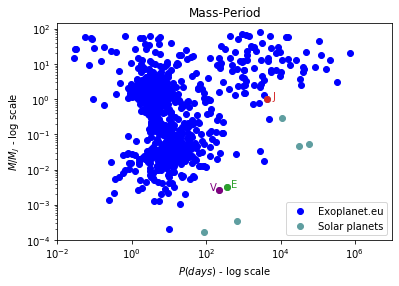

In [448]:
N = [1,2,5] #index of solar planets i'll distinguish on the plot
name, color = ['V','E','J'], ['purple','tab:green','tab:red']
d=[-100,100,1600] #this helps put the labels in the right place

plt.scatter(P_EU_MP, M_EU_MP, label = "Exoplanet.eu",c='b')
plt.scatter(P_solar, M_solar, label = "Solar planets",c='cadetblue')
for i,n in enumerate(N):
    plt.scatter(P_solar[n],M_solar[n],c=color[i])
    plt.annotate(name[i],(P_solar[n]+d[i],M_solar[n]),c=color[i])
plt.ylabel(r"$M/M_J$ - log scale")
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"$P (days)$ - log scale")
plt.ylim(10e-5,15e1)
plt.xlim(10e-3,10e6)
plt.legend(loc='lower right')
plt.title(r"Mass-Period")
plt.show()

Which is a first visualization for the relationship between orbital period and mass, in the full range we're studying, and also reproduces the figure in my document.

We can already see the three separate groups.

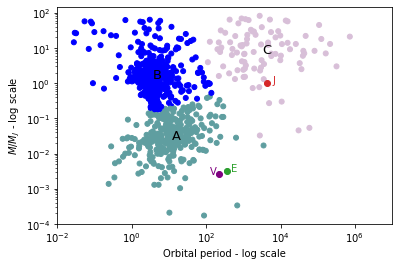

In [444]:
M,P = data_MP['obj_phys_mass_mjup'], data_MP['obj_orb_period_day']
kmeans = KMeans(n_clusters=3).fit(np.log(data_MP))
centroids, labels = kmeans.cluster_centers_, kmeans.labels_

colors, names = ['cadetblue','b','thistle'], ['A','B','C']
label_color = []
for l in labels:
    label_color=np.append(label_color,colors[l])

plt.scatter(P,M,c=label_color,s=25)
for i,n in enumerate(N):
    plt.scatter(P_solar[n],M_solar[n],c=color[i])
    plt.annotate(name[i],(P_solar[n]+d[i],M_solar[n]),c=color[i])
for i in range(3):
    plt.annotate(names[i],(np.exp(centroids[:,0][i]),np.exp(centroids[:,1][i])),c='k',size=13)
plt.xlabel('Orbital period - log scale')
plt.ylabel(r'$M/M_J$ - log scale')
plt.yscale('log')
plt.xscale('log')
plt.ylim(10e-5,15e1)
plt.xlim(10e-3,10e6)
plt.show()

Using a log scale, the three groups are easily found.

What to make of the study?
$\rightarrow$ Parallel coordinates plot

In [ ]:
#with standardization 
#d_2 = read_file(file_US,True,param_MP,True)
#M_2, P_2 = d_2[:,1], d_2[:,0]
#plt.scatter(P_2,M_2,c=label_color)
#plt.xscale('log')
#plt.yscale('log')
#plt.show()

#plt.ylim(10e-5,1.5e2)

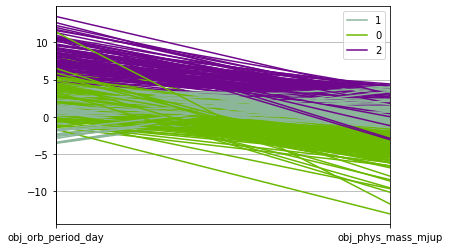

In [452]:
#a first Parallel Coordinates Plot - makes sense for a 2d plot? probably not. 
X_clustered = pd.DataFrame(np.log(data_MP), index=data_MP.index, columns=data_MP.columns)
X_clustered["cluster"] = labels
X_clustered
pd.plotting.parallel_coordinates(X_clustered,class_column='cluster',cols=['obj_orb_period_day','obj_phys_mass_mjup'])

For the centroids:


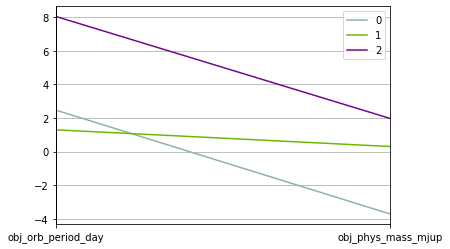

In [453]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=data_MP.columns)
centroids['cluster'] = centroids.index

pd.plotting.parallel_coordinates(centroids,class_column='cluster',cols=['obj_orb_period_day','obj_phys_mass_mjup'])